In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
import Double_Null_utils as dnu
from scipy import optimize

#!jupyter-theme -t onedork

In [2]:
###Initial Values###

M0=1.0
Q=0.95
Lambda=0.0005
scalarfield=False
vscalarfield=False

In [3]:
Tol=1.0
N=5
Nul=5
Nup=10**(80)#10**(20)#

scal=1
umax=13
vmax=150


ru0=5.0
dr0v=.4

bdytype="stan"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]

In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du00=1/N
    du0=du00
else:
    du00=M0/N
    du0=du00
dv00=du00
dv0=du0

wHD=False

def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M0,Q,Lambda), method='hybr')
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]



print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax*100#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(56000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.31304218328
r-: 0.687690417604
rc: 76.445748956
Number of points for highest iteration is 4875000,6500X750
Total number of points is 4875000
Runtime: about 1.45 minutes


In [5]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])

rnpf=np.zeros((Nv))
signpf=np.zeros((Nv))
phinpf=np.zeros((Nv))
#dphinpuf=np.zeros((Nu),len(Elist))) 
massnpf=np.zeros((Nv))


#tempsignpu=np.zeros((Nu*max(Elist),Nv*max(Elist)))




rnpf, signpf, phinpf = dnu.boundaryv(scal,bdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,scalarfield)



#print(rnpf)

In [6]:
drunp=np.empty((Nv))*np.nan
dsigunp=np.empty((Nv))*np.nan
urange=[0.0]

A=.115
u1=9.5
u2=10.5

###Applying Propagation Algorithm###


dphinpuf=np.array([0.0])


drunp[0]=-mth.exp(signpf[0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0+Lambda*ru0**2/3)
if bdytype=="edd":
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
    dsigunp[0]=2*(3*Q**2-3*M0*r+r**4*Lambda)/(r*(-3*Q**2+r*(6*M0-3*r+r**3*Lambda)))
else:
    dsigunp[0]=0.0

i=0
dv=dv0
du0=M0/Nul
if bdytype=="edd":
    bdyvalue=1.0
else:
    bdyvalue=0.0
    
while max(urange)<umax and i<2000:
    
    rnpf=np.insert(rnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    phinpf=np.insert(phinpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    signpf=np.insert(signpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    massnpf=np.insert(massnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    drunp=np.insert(drunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dsigunp=np.insert(dsigunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dphinpuf=np.insert(dphinpuf,(i+1),np.empty((1))*np.nan).reshape(i+2)
    #print(rnpf)
    
    du=abs(du0*Tol/mth.exp(np.nanmax(signpf[i,:])))
    
    #print(du)
    
    if du<1/Nup*1.1:
        du=1/Nup
     
    #print(du)
    
    if du>=1/Nul:
        #print('r='+str(rnpf[i][0]))
        if rnpf[i][0]<rplus:
            du=1/(10*Nul)
            #print(rplus)
        else:
            du=1/Nul
    
    print("%.80f" % du)
    print("%.64f" % urange[i])
    
    if urange[i]>u1 and urange[i]<u2 and vscalarfield==True:
        u=urange[i]+du
        phinpf[i+1][0]=A*64*(u-u1)**3.0*(u2-u)**3.0/(u2-u1)**6.0
        dphinpuf[i+1]=192*A*(u-u1)**2.0*(u-u2)**2.0*(-2*u+u1+u2)/(u1-u2)**6.0 
    else:
        phinpf[i+1][0]=0.0
        dphinpuf[i+1]=0.0
    
    rnpf[i+1][0]=rnpf[i][0]+du*drunp[i][0]
    drunp[i+1][0]=drunp[i][0]+du*(drunp[i][0]*dsigunp[i][0]-rnpf[i][0]*dphinpuf[i]**2.0)
    
    
    signpf[i+1][0]=signpf[i][0]+du*dsigunp[i][0]
    dsigunp[i+1][0]=2.0*(M0*rnpf[i+1][0]-Q**2.0)/(rnpf[i+1][0]*(Q**2.0+rnpf[i+1][0]*(-2*M0+rnpf[i+1][0])))*drunp[i+1][0]*bdyvalue
    
    
    
    
    #print(rnpf[1][0])
    for j in range(0,Nv-1):
        answer=dnu.x4giveralt(i,j,du,dv,rnpf,phinpf,signpf,Q,Lambda)
        rnpf[i+1][j+1]=answer[0]
        phinpf[i+1][j+1]=answer[1]
        signpf[i+1][j+1]=answer[2]
        massnpf[i+1][j+1]=answer[3]
        drunp[i+1][j+1]=answer[4]
        dsigunp[i+1][j+1]=answer[5]
        #dsignp[i+1][j+1]=answer[6]
            
        #print(rnpf[i+1][j+1])
        
        #du1=abs(du0*Tol/mth.exp(signpf[i][j+1])) #/(rnpf[i+1][j+1]-rnpf[i][j+1]))
        #print(du1)
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(mth.exp(signpf[i][j+1])*Tol*du))
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(Tol))
        #print(du1)
        #print(du1)
        #duminlist.append(du1)
    

    urange.append(urange[i]+du) 
    
    
    #du=np.nanmin(duminlist) 
    
    #print(urange[i]+du)
    if rnpf[i][0]<0.0:
        break
   
    dumaxlist=[]
    i+=1
    
    #if i>1000:
        #break
    
    


0.20000000000000001110223024625156540423631668090820312500000000000000000000000000
0.0000000000000000000000000000000000000000000000000000000000000000
0.19789446107772368232957660438842140138149261474609375000000000000000000000000000
0.2000000000000000111022302462515654042363166809082031250000000000
0.19576986480519584232773411258676787838339805603027343750000000000000000000000000
0.3978944610777236934318068506399868056178092956542968750000000000
0.19362604919409942549890502050402574241161346435546875000000000000000000000000000
0.5936643258829195080039653475978411734104156494140625000000000000
0.19146287648714896412194264030404156073927879333496093750000000000000000000000000
0.7872903750770189335028703681018669158220291137695312500000000000
0.18928023542018312941337399024632759392261505126953125000000000000000000000000000
0.9787532515641679253803886240348219871520996093750000000000000000
0.18707804358956389711998724578734254464507102966308593750000000000000000000000000
1.168033486984350

7.9044202721176830550575687084347009658813476562500000000000000000
0.05214987995424899547280972456064773723483085632324218750000000000000000000000000
7.9583691526723665532472296035848557949066162109375000000000000000
0.05039627220339023411233014826393628027290105819702148437500000000000000000000000
8.0105190326266146882971952436491847038269042968750000000000000000
0.04868823929338830791557768407074036076664924621582031250000000000000000000000000
8.0609153048300044019924825988709926605224609375000000000000000000
0.04702585209956589018531758483732119202613830566406250000000000000000000000000000
8.1096035441233933482862994424067437648773193359375000000000000000
0.04540907447922929579542383748957945499569177627563476562500000000000000000000000
8.1566293962229590164270121022127568721771240234375000000000000000
0.04383776795342736454230703202483709901571273803710937500000000000000000000000000
8.2020384707021882775279664201661944389343261718750000000000000000
0.0423116968888271535731426808979

0.00665959196163000682194832435811804316472262144088745117187500000000000000000000
9.2422517265150130327810984454117715358734130859375000000000000000
0.00643345308669054320033220406571672356221824884414672851562500000000000000000000
9.2489113184766438280348666012287139892578125000000000000000000000
0.00621559700535121752162925901075141155160963535308837890625000000000000000000000
9.2553447715633350156849701306782662868499755859375000000000000000
0.00600569969214493400849752546832860389258712530136108398437500000000000000000000
9.2615603685686860302439527004025876522064208984375000000000000000
0.00580345022079530210856734839808268588967621326446533203125000000000000000000000
9.2675660682608302920471032848581671714782714843750000000000000000
0.00560855026360271811947111331164705916307866573333740234375000000000000000000000
9.2733695184816262724325497401878237724304199218750000000000000000
0.00542071360374611361382379826068245165515691041946411132812500000000000000000000
9.278978068745228

0.00113158758607864078429838805561757908435538411140441894531250000000000000000000
9.4132833285195296468828018987551331520080566406250000000000000000
0.00109795022173634032429390128271506910095922648906707763671875000000000000000000
9.4144149161056080998832840123213827610015869140625000000000000000
0.00106537811984015262992131489738767413655295968055725097656250000000000000000000
9.4155128663273437439329427434131503105163574218750000000000000000
0.00103383522575748224535396868617453947081230580806732177734375000000000000000000
9.4165782444471837209221121156588196754455566406250000000000000000
0.00100328679435186416887826332811073370976373553276062011718750000000000000000000
9.4176120796729403394920154823921620845794677734375000000000000000
0.00097369933878055120891198415122858023096341639757156372070312500000000000000000
9.4186153664672929153311997652053833007812500000000000000000000000
0.00094504058144524228680938282565193730988539755344390869140625000000000000000000
9.419589065806073

9.4446337298248330682781670475378632545471191406250000000000000000
0.00022697044170411523637473361070249211479676887392997741699218750000000000000000
9.4448669962437108438280120026320219039916992187500000000000000000
0.00022085395741482327864116386173520822922000661492347717285156250000000000000000
9.4450939666854143439422841765917837619781494140625000000000000000
0.00021491156117692836137120226958074908907292410731315612792968750000000000000000
9.4453148206428299005210647010244429111480712890625000000000000000
0.00020913802019683280179057627279348707816097885370254516601562500000000000000000
9.4455297322040063789927444304339587688446044921875000000000000000
0.00020352826792040354820373382338516421441454440355300903320312500000000000000000
9.4457388702242024436372958007268607616424560546875000000000000000
0.00019807739844048265513351547717491030198289081454277038574218750000000000000000
9.4459423984921233596878664684481918811798095703125000000000000000
0.0001927806611042386889399297134

0.00005096608280578061709762890951758151913963956758379936218261718750000000000000
9.4516048930304528141732589574530720710754394531250000000000000000
0.00004970086552055820054490595238938510647130897268652915954589843750000000000000
9.4516558591132593392103444784879684448242187500000000000000000000
0.00004846870741681570926009600674966293354373192414641380310058593750000000000000
9.4517055599787802577793627278879284858703613281250000000000000000
0.00004726870023476854100778418721340301544842077419161796569824218750000000000000
9.4517540286861976284171760198660194873809814453125000000000000000
0.00004609996192996114119802900099820419654861325398087501525878906250000000000000
9.4518012973864315995342622045427560806274414062500000000000000000
0.00004496163587868066876520808938799689258303260430693626403808593750000000000000
9.4518473973483612127211017650552093982696533203125000000000000000
0.00004385289010871227507798106315384245590394129976630210876464843750000000000000
9.451892358984240

0.00001193317465677530526220115336677451978175668045878410339355468750000000000000
9.4532231782956195331735216313973069190979003906250000000000000000
0.00001165849400580484098246831364820152998618141282349824905395507812500000000000
9.4532351114702759531382980640046298503875732421875000000000000000
0.00001139045369126413058120765586789246981425094418227672576904296875000000000000
9.4532467699642825920136601780541241168975830078125000000000000000
0.00001112888530215892426012812971292120778343814890831708908081054687500000000000
9.4532581604179739542814786545932292938232421875000000000000000000
0.00001087362490337789674055453403855864280558307655155658721923828125000000000000
9.4532692893032752579074440291151404380798339843750000000000000000
0.00001062451291117049631789869684750371447989891748875379562377929687500000000000
9.4532801629281788535763553227297961711883544921875000000000000000
0.00001038139397224903444512909833630232014911598525941371917724609375000000000000
9.453290787441089

0.00000330051455654259645686871005310081272909883409738540649414062500000000000000
9.4536077764075425733381052850745618343353271484375000000000000000
0.00000322926231644470863892918029158796144884036039002239704132080078125000000000
9.4536110769220993432782051968388259410858154296875000000000000000
0.00000315962266017289999825456460469386144040981889702379703521728515625000000000
9.4536143061844164492413256084546446800231933593750000000000000000
0.00000309155736137475065574841022464358530896788579411804676055908203125000000000
9.4536174658070759591055320925079286098480224609375000000000000000
0.00000302502914183318097790824016679600561019469751045107841491699218750000000000
9.4536205573644380706355150323361158370971679687500000000000000000
0.00000296000164688806817074378727183692205926490714773535728454589843750000000000
9.4536235823935790278937929542735219001770019531250000000000000000
0.00000289643942152095838128852099691012966786729521118104457855224609375000000000
9.453626542395225

0.00000100640401027017952848160130263632794367367750965058803558349609375000000000
9.4537164923549479311759569100104272365570068359375000000000000000
0.00000098588149785462052458284536171628786860310356132686138153076171875000000000
9.4537174987589587260572443483397364616394042968750000000000000000
0.00000096579695343945550688397397309792324904265115037560462951660156250000000000
9.4537184846404560545352069311775267124176025390625000000000000000
0.00000094614060191210385481125951651071304127071925904601812362670898437500000000
9.4537194504374095771481734118424355983734130859375000000000000000
0.00000092690289614125512353867263753981475815635349135845899581909179687500000000
9.4537203965780118863904135650955140590667724609375000000000000000
0.00000090807451142605377052542756782793631487038510385900735855102539062500000000
9.4537213234809076567444208194501698017120361328125000000000000000
0.00000088964634008646743958099263258065825255016534356400370597839355468750000000
9.453722231555419

0.00000032068648870994761350595612589553518034790613455697894096374511718750000000
9.4537508421975697814332306734286248683929443359375000000000000000
0.00000031448300560118368835021691702624746511673947679810225963592529296875000000
9.4537511628840587007971407729201018810272216796875000000000000000
0.00000030840488552710131814392578025740832003975810948759317398071289062500000000
9.4537514773670636714086867868900299072265625000000000000000000000
0.00000030244948298260653814697866172134244067137842648662626743316650390625000000
9.4537517857719493008517019916325807571411132812500000000000000000
0.00000029661421072349232410338333056076809413070805021561682224273681640625000000
9.4537520882214316486624738899990916252136230468750000000000000000
0.00000029089653842852977620191709355601528130819133366458117961883544921875000000
9.4537523848356421751759626204147934913635253906250000000000000000
0.00000028529399139351446800490024434393543373289503506384789943695068359375000000
9.453752675732181

0.00000010615801180345348949553280345700634335059930890565738081932067871093750000
9.4537621545457160010528241400606930255889892578125000000000000000
0.00000010420231887278082754617132728303108279988009599037468433380126953125000000
9.4537622607037281596831235219724476337432861328125000000000000000
0.00000010228419441844059581550537051455873616134795156540349125862121582031250000
9.4537623649060478214778413530439138412475585937500000000000000000
0.00000010040288601390651995923198550736410439299106656108051538467407226562500000
9.4537624671902413808766141301020979881286621093750000000000000000
0.00000009855765693794811462725036655535548746343010861892253160476684570312500000
9.4537625675931273860896908445283770561218261718750000000000000000
0.00000009674778583317919545459158143368982862853044935036450624465942382812500000
9.4537626661507836445252905832603573799133300781250000000000000000
0.00000009497256637236625840549196107473473027482668840093538165092468261718750000
9.453762762898570

0.00000003568477317412600757301705325930107903786847600713372230529785156250000000
9.4537660523914723853522446006536483764648437500000000000000000000
0.00000003505689229452478359323793345551922850944492893177084624767303466796875000
9.4537660880762448556424715206958353519439697265625000000000000000
0.00000003444050870118551960592171833769326028118484828155487775802612304687500000
9.4537661231331373556940889102406799793243408203125000000000000000
0.00000003383540326460024592760235991745210171188773529138416051864624023437500000
9.4537661575736464669716951902955770492553710937500000000000000000
0.00000003324136120158507889271894521557304535974708414869382977485656738281250000
9.4537661914090502790486425510607659816741943359375000000000000000
0.00000003265817198561036167684987316546518787419017826323397457599639892578125000
9.4537662246504119423207157524302601814270019531250000000000000000
0.00000003208562925904597308346860628017194194683270325185731053352355957031250000
9.453766257308583

0.00000001301098548194176728979273621657902770820669502427335828542709350585937500
9.4537673628027114602900837780907750129699707031250000000000000000
0.00000001279112632499714573744624635182401406474639316002139821648597717285156250
9.4537673758136975266097579151391983032226562500000000000000000000
0.00000001257512602623991825644514960889225330120666512812022119760513305664062500
9.4537673886048239069168630521744489669799804687500000000000000000
0.00000001236291420807784422323257302652604883164144666807260364294052124023437500
9.4537674011799506246234159334562718868255615234375000000000000000
0.00000001215442182675827005692301488459783342932496452704071998596191406250000000
9.4537674135428648725110178929753601551055908203125000000000000000
0.00000001194958114609623272682406970677387869628205407934729009866714477539062500
9.4537674256972863418013730552047491073608398437500000000000000000
0.00000001174832571175407600721053382906641782135181983903748914599418640136718750
9.453767437646867

9.4537678533438445072079048259183764457702636718750000000000000000
0.00000000477132706203966447473591231927605993412555562827037647366523742675781250
9.4537678581941158029167127097025513648986816406250000000000000000
0.00000000469371403555943775903201877061285407499724442459410056471824645996093750
9.4537678629654422479688946623355150222778320312500000000000000000
0.00000000461740962729795278819626861235327075494438986424938775599002838134765625
9.4537678676591561099940008716657757759094238281250000000000000000
0.00000000454239095079221316450499259706995169860732630695565603673458099365234375
9.4537678722765665639826693222858011722564697265625000000000000000
0.00000000446863553488911152879299538889096288230007303354796022176742553710937500
9.4537678768189579159297863952815532684326171875000000000000000000
0.00000000439612131592432602656259679188219258172409809048986062407493591308593750
9.4537678812875931555481656687334179878234863281250000000000000000
0.0000000043248266300546356166641

0.00000000181403547056824946166271531197092953258120928694552276283502578735351562
9.4537680426480168449643315398134291172027587890625000000000000000
0.00000000178553034982770556137205603694593364361153930985892657190561294555664062
9.4537680444620519892851007170975208282470703125000000000000000000
0.00000000175748852513241284181911465792080839776190259726718068122863769531250000
9.4537680462475819354040140751749277114868164062500000000000000000
0.00000000172990220029344115473080510761742442649158135736797703430056571960449219
9.4537680480050703124561550794169306755065917968750000000000000000
0.00000000170276371502947464397880623367901448128591823660826776176691055297851562
9.4537680497349718677924101939424872398376464843750000000000000000
0.00000000167606554251153847583817213566991996542832055183680495247244834899902344
9.4537680514377360196931476821191608905792236328125000000000000000
0.00000000164980028695451648816107648030286972340441309370362432673573493957519531
9.453768053113801

0.00000000076869802970354576355114316791130625594608005712871090508997440338134766
9.4537681099954706809285198687575757503509521484375000000000000000
0.00000000075696234819093549084648698513540232557517128952895291149616241455078125
9.4537681107641695632537448545917868614196777343750000000000000000
0.00000000074541161267510256614438473533250199831723392662752303294837474822998047
9.4537681115211320559410523856058716773986816406250000000000000000
0.00000000073404281075808061886116370509417980438904294260282767936587333679199219
9.4537681122665429001017400878481566905975341796875000000000000000
0.00000000072285298079496873081514448080241684591040751683976850472390651702880859
9.4537681130005850604902661871165037155151367187500000000000000000
0.00000000071183921100935038282429759344429980039148375681179459206759929656982422
9.4537681137234379491474101087078452110290527343750000000000000000
0.00000000070099863862391722173354364163236872309337144315577461384236812591552734
9.453768114435277

0.00000000031883863659802270458690149127194829459241987024142872542142868041992188
9.4537681398105277708054927643388509750366210937500000000000000000
0.00000000031410356826922833969386766362914126249350488251366186887025833129882812
9.4537681401293660599094437202438712120056152343750000000000000000
0.00000000030944092867936047644747340966647590476679141602289746515452861785888672
9.4537681404434703580363930086605250835418701171875000000000000000
0.00000000030484957495164566407357164907131977932275290754660090897232294082641602
9.4537681407529117194599166396073997020721435546875000000000000000
0.00000000030032838283262371445699432948852822256036176895577227696776390075683594
9.4537681410577611984535906231030821800231933593750000000000000000
0.00000000029587624637853980217887701999527044066651271236878528725355863571166992
9.4537681413580898492909909691661596298217773437500000000000000000
0.00000000029149207764716871133540752188096582125931277573727129492908716201782227
9.453768141653966

0.00000000013336344641986300194237830301811301852987767802005691919475793838500977
9.4537681524355097195666530751623213291168212890625000000000000000
0.00000000013143236566729845899686919258179170627576226593191677238792181015014648
9.4537681525688732619983056792989373207092285156250000000000000000
0.00000000012953001800144411667668773791625008717787181922176387161016464233398438
9.4537681527003059045455302111804485321044921875000000000000000000
0.00000000012765596328031783945437957293990785534454346361599164083600044250488281
9.4537681528298360689177570748142898082733154296875000000000000000
0.00000000012580976831240339398539414356918524073858378642398747615516185760498047
9.4537681529574921768244166742078959941864013671875000000000000000
0.00000000012399100674345845955026312820045812992941769437038601608946919441223145
9.4537681530833026499749394133687019348144531250000000000000000000
0.00000000012219925894508205165967914805646467313327008241685689426958560943603516
9.453768153207294

0.00000000006030120815801732109507745279236502929098850955824673292227089405059814
9.4537681575277918710753510822542011737823486328125000000000000000
0.00000000005944633365578048724827479648821272097125589795041378238238394260406494
9.4537681575880938567024713847786188125610351562500000000000000000
0.00000000005860388457870633854566863904067119256380280489793221931904554367065430
9.4537681576475396383330007665790617465972900390625000000000000000
0.00000000005777367536108343341459791802454111324383045911190492915920913219451904
9.4537681577061434268216544296592473983764648437500000000000000000
0.00000000005695552328928974330288950377089722716672515190339254331775009632110596
9.4537681577639176566663081757724285125732421875000000000000000000
0.00000000005614924845659684171510763031155753863959967375762971641961485147476196
9.4537681578208729860079984064213931560516357421875000000000000000
0.00000000005535467371876275826408435364731270601768020611643805750645697116851807
9.453768157877021

0.00000000002770124682444615119698141164840166127472653734287177940132096409797668
9.4537681598463141341426307917572557926177978515625000000000000000
0.00000000002731587110537796669070996223084059340013851624462404288351535797119141
9.4537681598740146426962382975034415721893310546875000000000000000
0.00000000002693597899259077031146692783336740002406162197701178229181095957756042
9.4537681599013296818156959488987922668457031250000000000000000000
0.00000000002656149047777194202676804507231770159994543867298943951027467846870422
9.4537681599282663569283613469451665878295898437500000000000000000
0.00000000002619232675187411931774708383114134502625547362697489006677642464637756
9.4537681599548282207479132921434938907623291015625000000000000000
0.00000000002582841018660527967682871342187424235081749657183536328375339508056641
9.4537681599810206023448699852451682090759277343750000000000000000
0.00000000002546966431624712979805395831666092959846836585313667455920949578285217
9.453768160006848

0.00000000001171680811009661355706448739951071064818721723099770315457135438919067
9.4537681610045591895641337032429873943328857421875000000000000000
0.00000000001155680052327380380473644183567013534949530217943447496509179472923279
9.4537681610162760392768177553080022335052490234375000000000000000
0.00000000001139902151364352478695083210339571242603051715036599489394575357437134
9.4537681610278330168739557848311960697174072265625000000000000000
0.00000000001124343933135783662362460766034289393576484084036337662837468087673187
9.4537681610392318987123871920630335807800292968750000000000000000
0.00000000001109002269028432505203843247952328471273020227272354532033205032348633
9.4537681610504744611489513772539794445037841796875000000000000000
0.00000000001093874076105747570424867908763891005859136829059252704610116779804230
9.4537681610615642568973271409049630165100097656250000000000000000
0.00000000001078956316422600456672984159896592180893915013939476921223104000091553
9.453768161072503

0.00000000000496170172351930382807062807779270694093221027998197314445860683917999
9.4537681615026478709751245332881808280944824218750000000000000000
0.00000000000489501089254087163897966355803586374888930476956261372833978384733200
9.4537681615076092356275694328360259532928466796875000000000000000
0.00000000000482923143308065796074954338097465764752941330684166132414247840642929
9.4537681615125048750769565231166779994964599609375000000000000000
0.00000000000476435063937609283903211112235028445918011419379922699590679258108139
9.4537681615173347893232858041301369667053222656250000000000000000
0.00000000000470035598685118877259988471998068389288288893013145752775017172098160
9.4537681615220989783665572758764028549194335937500000000000000000
0.00000000000463723512946684210444289272158514998711797971964188036508858203887939
9.4537681615267992185636103386059403419494628906250000000000000000
0.00000000000457497589711208793112255486567596369888721863361524810898117721080780
9.453768161531437

0.00000000000230487926953808456667094583592441433671921258152792688633780926465988
9.4537681617013440416030789492651820182800292968750000000000000000
0.00000000000227426012073936928503471996079098933112375147125305829831631854176521
9.4537681617036497527806204743683338165283203125000000000000000000
0.00000000000224405324624839157310539327919752812089820848129306796181481331586838
9.4537681617059234895350527949631214141845703125000000000000000000
0.00000000000221425299754475900820626647395885874293475215068838224397040903568268
9.4537681617081670282232153113000094890594482421875000000000000000
0.00000000000218485380509396652650628602445602612211125737040617877937620505690575
9.4537681617103821452019474236294627189636230468750000000000000000
0.00000000000215585017721852753143244196947037679031045076527561832335777580738068
9.4537681617125670641144097317010164260864257812500000000000000000
0.00000000000212723669898332540003468861844385090877421196076113574235932901501656
9.453768161714723

0.00000000000110830641602460315957389888842361978988672321921882257811375893652439
9.4537681617917801446537851006723940372467041015625000000000000000
0.00000000000109371225610591576131414908009508913278202968388796989529510028660297
9.4537681617928885913215708569623529911041259765625000000000000000
0.00000000000107931223608053832998719860340596998706137743528898909062263555824757
9.4537681617939828271346414112485945224761962890625000000000000000
0.00000000000106510373514179603433050463725390361231261382446433572113164700567722
9.4537681617950628520929967635311186313629150390625000000000000000
0.00000000000105108416851141774973165254660739174170057397272870503002195619046688
9.4537681617961286661966369138099253177642822265625000000000000000
0.00000000000103725098693369855388405705984211096376025607046500454089255072176456
9.4537681617971802694455618620850145816802978515625000000000000000
0.00000000000102360167617707998881953973014111912388443559329687104764161631464958
9.453768161798217

9.4537681618359155066855237237177789211273193359375000000000000000
0.00000000000052195361156893529464868252779646290862979735036830675198871176689863
9.4537681618364448610236649983562529087066650390625000000000000000
0.00000000000051512396669802218165155502957364190780645274436722047539660707116127
9.4537681618369671099344486719928681850433349609375000000000000000
0.00000000000050838425376264157807632815229319106779988513000745342651498503983021
9.4537681618374822534178747446276247501373291015625000000000000000
0.00000000000050173327468983250984660800042625716766396537504846264710067771375179
9.4537681618379902914739432162605226039886474609375000000000000000
0.00000000000049516984761900504921364037605006462063311073462656963783956598490477
9.4537681618384912241026540868915617465972900390625000000000000000
0.00000000000048869280667830882517317113533997738632121826674037379234505351632833
9.4537681618389868276608467567712068557739257812500000000000000000
0.0000000000004823010017643689223

0.00000000000025327511664436324939557420892223690915253178634891639831039356067777
9.4537681618570061914397228974848985671997070312500000000000000000
0.00000000000024997144421570578430316913545565589476133219748454905584367224946618
9.4537681618572602104677571333013474941253662109375000000000000000
0.00000000000024671095400799693750318438541871932134005168668622332006634678691626
9.4537681618575106767821125686168670654296875000000000000000000000
0.00000000000024349307686054706304681005278979779248536841063099700477323494851589
9.4537681618577575903827892034314572811126708984375000000000000000
0.00000000000024031725121242444060410297378378936453526340533137783950223820284009
9.4537681618580009512697870377451181411743164062500000000000000000
0.00000000000023718292299938591551852814254900028549406104660945970863394904881716
9.4537681618582407594431060715578496456146240234375000000000000000
0.00000000000023408954555212621137244205373414086601485326055716029713948955759406
9.453768161858478

0.00000000000012143226562270840458288788192386192744866985071539033924636896699667
9.4537681618671154382127497228793799877166748046875000000000000000
0.00000000000011984792529226006893376288851257564934370269948971099438495002686977
9.4537681618672362304778289399109780788421630859375000000000000000
0.00000000000011828419396884801317016681647489409240532609590701440538396127521992
9.4537681618673552463860687566921114921569824218750000000000000000
0.00000000000011674080235586021301774882133523616374614663426800831302898586727679
9.4537681618674742622943085734732449054718017578125000000000000000
0.00000000000011521748471097429403848251621850536701645133230709205918174120597541
9.4537681618675915018457089900039136409759521484375000000000000000
0.00000000000011371397879852260132011485597881916026377462081153879580597276799381
9.4537681618677069650402700062841176986694335937500000000000000000
0.00000000000011223002584259197003652717934713769472137006449896645676744810771197
9.453768161867820

0.00000000000005513707092922447502611667978909982548528902548956587281736574368551
9.4537681618721851606323980377055704593658447265625000000000000000
0.00000000000005441417655301912770945598403025894926045248276014199007022398291156
9.4537681618722402276944194454699754714965820312500000000000000000
0.00000000000005370066894736436086266234323130949827309818522813600338849937543273
9.4537681618722952947564408532343804836273193359375000000000000000
0.00000000000005299642626088280268475757706011678285827701945231993363449873868376
9.4537681618723485854616228607483208179473876953125000000000000000
0.00000000000005230132823416844606836703303053856473954106795498653070808359188959
9.4537681618724018761668048682622611522674560546875000000000000000
0.00000000000005161525617877817828841673270778314891547161602503024369070772081614
9.4537681618724533905151474755257368087768554687500000000000000000
0.00000000000005093809295645388526709575701234765886509653354252691315195988863707
9.453768161872504

0.00000000000002555509640633627881530708870622042483110596296225214274500103783794
9.4537681618744340283910787547938525676727294921875000000000000000
0.00000000000002521656474889130689446892785285032461336531504902946920765316463076
9.4537681618744588973868303583003580570220947265625000000000000000
0.00000000000002488243905486461003270937329261858874786890634400737809528436628170
9.4537681618744837663825819618068635463714599609375000000000000000
0.00000000000002455266232951434454524321642252777007448200433104013029605994233862
9.4537681618745086353783335653133690357208251953125000000000000000
0.00000000000002422717831732513485394396486114456606248638431688746663894562516361
9.4537681618745335043740851688198745250701904296875000000000000000
0.00000000000002390593149233643053005525936713539790387213559985646327277208911255
9.4537681618745583733698367723263800144195556640625000000000000000
0.00000000000002358886704861739267232528325863360736417361461503272579420809051953
9.453768161874581

0.00000000000001204100275881636402565122369143542039634901547745515770770907693077
9.4537681618754447754326974973082542419433593750000000000000000000
0.00000000000001187881367667953098754544678516349337751476476776613111496772035025
9.4537681618754572099305732990615069866180419921875000000000000000
0.00000000000001171875055091670889082142868651216331349145492735086548918843618594
9.4537681618754696444284491008147597312927246093750000000000000000
0.00000000000001156078589946383550272752065050149759068071671913591202951465675142
9.4537681618754820789263249025680124759674072265625000000000000000
0.00000000000001140489259532110676935401733751262856956783329348548150505848752800
9.4537681618754945134242007043212652206420898437500000000000000000
0.00000000000001125104386195962593570483722916133531702148271036456605997955193743
9.4537681618755051715652371058240532875061035156250000000000000000
0.00000000000001109921326878005753208499302643158813253118286090703747959196334705
9.453768161875515

0.00000000000000558522957665636130058080171621644679515704401406850365674472413957
9.4537681618759208390656567644327878952026367187500000000000000000
0.00000000000000550813307333377516273714229171459414814758601824928874179931881372
9.4537681618759261681361749651841819286346435546875000000000000000
0.00000000000000543206238618745942510316538537920931558608062320048226467861240963
9.4537681618759314972066931659355759620666503906250000000000000000
0.00000000000000535700425787450431878469600381422877817820700496742603036182117648
9.4537681618759368262772113666869699954986572265625000000000000000
0.00000000000000528294560322298785393765269208852194066713004599877834266408171970
9.4537681618759421553477295674383640289306640625000000000000000000
0.00000000000000520987350705265132806456545784573073935483887575426109606269164942
9.4537681618759474844182477681897580623626708984375000000000000000
0.00000000000000513777522202680978185331965784938664216585733207631747632149199490
9.453768161875952

0.00000000000000257239648659561711204338182532551591308119681190957894756365931244
9.4537681618761428836705817957408726215362548828125000000000000000
0.00000000000000253590192597828307041359780106480339769377588786392063724406398251
9.4537681618761446600274211959913372993469238281250000000000000000
0.00000000000000249991176240291144474054208215428607975835940090136855218361233710
9.4537681618761464363842605962418019771575927734375000000000000000
0.00000000000000246441966909032068764595918270525894126600561888362772577920623007
9.4537681618761482127410999964922666549682617187500000000000000000
0.00000000000000242941941019994986159876526276901096911722106007347488088043974130
9.4537681618761499890979393967427313327789306640625000000000000000
0.00000000000000239490484007105648962657775675850509509070954995701985268397038453
9.4537681618761517654547787969931960105895996093750000000000000000
0.00000000000000236086990249343358110061526362856501872500313878033839642966995598
9.453768161876153

0.00000000000000117791026627143630501342229774893275738056918396784444880154296698
9.4537681618762405832967488095164299011230468750000000000000000000
0.00000000000000116206133919641337767105948708844661572715264118149658401080159820
9.4537681618762423596535882097668945789337158203125000000000000000
0.00000000000000114650384041573905671503184836833721187890464034836446316489855235
9.4537681618762441360104276100173592567443847656250000000000000000
0.00000000000000113123733396636413876042069371539337028248375753569643364926378126
9.4537681618762459123672670102678239345550537109375000000000000000
0.00000000000000111626162162444645881358255362268644920630737780303798345471477660
9.4537681618762476887241064105182886123657226562500000000000000000
0.00000000000000110157676008888276891300873536280862979009590070511581672008105670
9.4537681618762494650809458107687532901763916015625000000000000000
0.00000000000000108718308011365876867672947623225639320460034469711940730007881939
9.453768161876251

0.00000000000000170923222573094269990685843179691700593938585156505993722930725198
9.4537681618763009794292884180322289466857910156250000000000000000
0.00000000000000198673971009031872428913213105153813053878634684035198176843550755
9.4537681618763027557861278182826936244964599609375000000000000000
0.00000000000000230369537252987099433927835683525631483244459039860796423226929619
9.4537681618763045321429672185331583023071289062500000000000000000
0.00000000000000268226133474730229363901607314487767779026517432627851889037629007
9.4537681618763063084998066187836229801177978515625000000000000000
0.00000000000000312301927784186405887827853145313633675367683863177692416002173559
9.4537681618763098612134854192845523357391357421875000000000000000
0.00000000000000364542901998298814876162982561740101147357501557011438819699833402
9.4537681618763134139271642197854816913604736328125000000000000000
0.00000000000000425773641111084897302257409986689358089706610929758845429660141235
9.453768161876316

0.00000000031668873294867833443882239414179056991027749745626351796090602874755859
9.4537681628918548426554480101913213729858398437500000000000000000
0.00000000042165289968652106871183263107644850764543775767378974705934524536132812
9.4537681632085437399837246630340814590454101562500000000000000000
0.00000000056332618610937164635179257309071168546843466629070462659001350402832031
9.4537681636301957865953227155841886997222900390625000000000000000
0.00000000075561956147770711358850898850319718902390775383537402376532554626464844
9.4537681641935211729332877439446747303009033203125000000000000000
0.00000000101694506209961249554567935815541090960323344916105270385742187500000000
9.4537681649491407398500086856074631214141845703125000000000000000
0.00000000137383738419264041077874090703361820153816097445087507367134094238281250
9.4537681659660854904814186738803982734680175781250000000000000000
0.00000000186248199647524855915192177751053478895748582999658538028597831726074219
9.453768167339923

In [7]:
Nu=i+2

print(Nu)
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

2002


In [8]:
#print(rnpf[1,0])

In [9]:
#print(dnu.x4giveralt(0,0,du,dv,rnpf,phinpf,signpf,Q,Lambda))

In [10]:
#print(rnpf)

In [11]:
vrange=np.arange(0,vmax,dv0)
#print(urange)

In [12]:
np.save('rnp.npy',rnpf)
np.save('sig.npy',signpf)
np.save('phi.npy',phinpf)
np.save('mass.npy',massnpf)
np.save('rnputil',np.array([N,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD]))
np.save('urange',urange)
np.save('vrange',vrange)

In [13]:
M=massnpf[10][-10]
#rplus=M+(M**2.0-Q**2.0)**.5
#rminus=M-(M**2.0-Q**2.0)**.5
print(M)

22.6421998181


In [14]:
levels=np.arange(10.0, np.nanmax(rnpf), 10.0 )


if rplus==0.0 and scalarfield==False:
    levels=np.insert(levels,0,[ru0])
if Q==0.0 and scalarfield==False and M0>0.0:
    levels=np.insert(levels,0,[1.0,rplus,3.0,4.0,ru0])
if scalarfield==True and Q==0.0 and M0>0.0:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q>0.0:
    levels=np.insert(levels,0,[.1,.2,.3,.4,.5,rminus,rplus,ru0])
if scalarfield==False and Q>0.0 and Lambda==0.0:
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.001,rminus+0.002,rminus+0.003,rminus+0.004,rminus+0.005,rminus+0.006,rminus+0.007,rminus+0.008,rminus+0.009,rminus+0.01,rminus+0.011,rminus+0.012,rminus+0.013,rminus+0.014,rminus+0.015,rminus+0.016,rminus+0.017,rminus+0.018,rminus+0.020,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.003,rminus+0.006,rminus+0.009,rminus+0.012,rminus+0.015,rminus+0.018,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus-.01,rminus,.689,.690,.691,0.7,0.8,0.9,1.0,rplus,ru0])
    #levels=np.insert(levels,0,[.5,.6,.65,.67,.68,.685,.687,.8,.9,1.0,ru0])
    levels=np.insert(levels,0,[.6,.683,.685,.69,1.0])#,10.0,15.0,20.0,25.0,30.0]
#if scalarfield==False and Lambda>0:
    #levels=np.insert(levels,0,[rminus,rplus])
    #levels=np.insert(levels,-1,[rcosm])
print(levels)  
print(np.nanmin(rnpf))
print(np.nanmax(rnpf))

[ 10.  20.  30.  40.  50.  60.]
0.720583072091
64.92


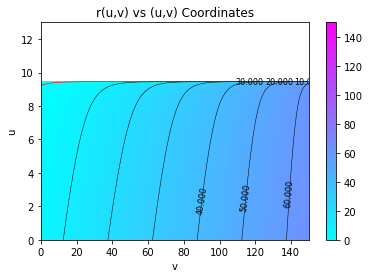

In [15]:
plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(rnpf),cmap=plt.cm.cool,vmin=0.0,vmax=150)#np.nanmax(rnpf))#np.nanmax(rnpf[:,:,-1]))#np.nanmax(rnpf[:,:,-1]))# norm=LogNorm(vmin=0.6, vmax=.8))#

plt.xlim(0,vmax)
plt.ylim(0,umax)
#plt.xlim(0,5)
#plt.ylim(9.45378,9.45379)


plot4=plt.contour(vrange,urange,rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rnpf, [rminus],linewidths=0.6,colors='yellow',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rplus],linewidths=0.6,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rcosm],linewidths=0.6,colors='green',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels, inline=0, inline_spacing=0, fmt='%1.3f',rightside_up=True, fontsize=8)
if solveaffine==True:
    CHorizon=plt.plot(CH.list,urange[-1][int(uEH*Nu*Elist[-1]):],color='g')
#sample3=plt.plot(vrange[-1],drdvnplistscal)

plt.xlabel('v')
plt.ylabel('u')


plt.colorbar(plot1)
plt.title('r(u,v) vs (u,v) Coordinates')
#plt.grid()
#plt.savefig('ruv-Lambda-.0005.png',dpi=300)
plt.show()

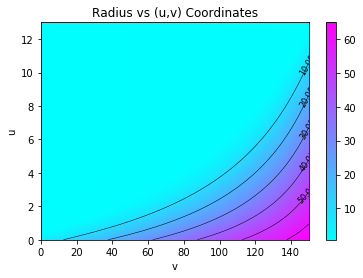

In [16]:
plot1=plt.imshow(rnpf,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#plot1=plt.contourf(rnpf,levels,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot4=plt.contour(rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels,  inline=0, inline_spacing=0, fmt='%1.2f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim()
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
#plt.savefig('Test1-2.png',dpi=300)
plt.show()

In [17]:
stop = timeit.default_timer()

In [18]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttime=format((acttime-predtime)/60,'.2f')

print("Took "+str(exttime)+" more minutes")

49.34462438380258 seconds
0.8224104063967097 minutes
0.013706840106611828 hours
1501500 points
30428.846480243323 points per second
Took -0.63 more minutes


In [19]:
print(signpf[:,:])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.30047111e-04   4.50912938e-04 ...,   1.05765178e-02
    1.05800106e-02   1.05835028e-02]
 [  0.00000000e+00   4.67348072e-04   9.16043941e-04 ...,   2.13635852e-02
    2.13705713e-02   2.13775563e-02]
 ..., 
 [  0.00000000e+00   3.21894045e-02   6.43580986e-02 ...,  -6.27114695e+01
   -6.29990011e+01  -6.32886978e+01]
 [  0.00000000e+00   3.21763949e-02   6.43316546e-02 ...,  -6.42712776e+01
   -6.45588091e+01  -6.48485058e+01]
 [  0.00000000e+00   3.21564064e-02   6.42910216e-02 ...,  -6.58353722e+01
   -6.61229036e+01  -6.64126002e+01]]


In [20]:
print(dsigunp)

[[  0.00000000e+00              nan              nan ...,              nan
               nan              nan]
 [ -0.00000000e+00   5.75117777e-04   1.70240012e-03 ...,   5.28738560e-02
    5.28913210e-02   5.29087835e-02]
 [ -0.00000000e+00   5.99564434e-04   1.77476408e-03 ...,   5.45003655e-02
    5.45180192e-02   5.45356704e-02]
 ..., 
 [  0.00000000e+00  -7.55622676e-03  -2.29146973e-02 ...,  -2.76815352e+03
   -2.76815336e+03  -2.76815320e+03]
 [  0.00000000e+00  -7.57659598e-03  -2.29772378e-02 ...,  -1.81682031e+03
   -1.81682021e+03  -1.81682011e+03]
 [  0.00000000e+00  -7.60782139e-03  -2.30731115e-02 ...,  -1.19061769e+03
   -1.19061763e+03  -1.19061756e+03]]


9.453768161876306


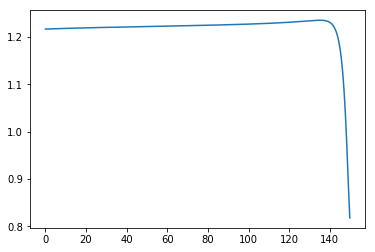

In [21]:
print(urange[-100])

plt.plot(vrange,rnpf[-100,:])
#plt.plot(vrange,rnpf[0,:])
plt.show()